In [160]:
import os

import numpy as np
from PIL import Image

from tqdm.notebook import tqdm
import scipy.ndimage

from heart_seg_app.utils.config import save_config
from heart_seg_app.utils.dataset import split_dataset


dataset = {
    "sources": [],
    "size": 0,
    "train": [],
    "val": [],
    "test" : [],
}

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
DATASET_PATH = "data/CT_HD_united_lamiax"
os.chdir(ROOT_DIR)

# Uniting Datasets

## Preparing Dataset

`CT Heart Dataset`

In [161]:
DATA_PATH = "data/datasets/CT_HD_25_nikhilroxtomar/train"

dataset["sources"].append("https://www.kaggle.com/datasets/nikhilroxtomar/ct-heart-segmentation")

In [162]:
# - CT_HD_25_nikhilroxtomar/
# - - train/ < - DATA_PATH
# - - - idx_0/
# - - - - image/
# - - - - - image_0.png
# - - - - ...
# - - - - idx_1/
# - - - - - image_0.png
# - - - - ...

def zoom(image : np.ndarray, target_shape=(256.0, 256.0, 128.0), order=3):
    scales = [ts / s for s, ts in zip(image.shape, target_shape)]
    scaled_image = scipy.ndimage.zoom(image, scales, mode="reflect", order=order)
    # print(f"source_shape: {image.shape}", f"target_shape:{scaled_image.shape}")
    
    return scaled_image

def convert_png_to_numpy(paths_to_png_files):
    width, height = Image.open(paths_to_png_files[0]).size
    depth = len(paths_to_png_files)
    volume = np.zeros((width, height, depth))
    
    for i, png_file in enumerate(paths_to_png_files):
        image = Image.open(png_file)
        volume[:,:,i] = np.array(image)
    
    volume = volume / 255.0
    
    return volume

data = []
target_shape = (128.0, 128.0, 128.0)

for idx in tqdm(sorted(os.listdir(DATA_PATH))):
    image_path_png = os.path.join(DATA_PATH, idx, "image")
    label_path_png = os.path.join(DATA_PATH, idx, "mask")
    
    image_png = [os.path.join(image_path_png, path) for path in sorted(os.listdir(image_path_png))]
    label_png = [os.path.join(label_path_png, path) for path in sorted(os.listdir(label_path_png))]
    
    # image = convert_png_to_numpy(image_png)
    label = convert_png_to_numpy(label_png)
    
    # image = zoom(image, target_shape, order=3)
    label = zoom(label, target_shape, order=0)
    
    image_path = os.path.join(DATASET_PATH, f"ct_nikhilroxtomar_{idx}_image.npy")
    label_path = os.path.join(DATASET_PATH, f"ct_nikhilroxtomar_{idx}_label.npy")
    
    # np.save(image_path, image)
    np.save(label_path, label)
    
    data.append({"image": image_path,
                "label": label_path,
                "label_map": {
                    "background": {"color": "black", "value": [0.0]},
                    "left ventricle": {"color": "yellow", "value": []},
                    "right ventricle": {"color": "skyblue", "value": []},
                    "left atrium": {"color": "red", "value": []},
                    "right atrium": {"color": "purple", "value": []},
                    "myocarium": {"color": "blue", "value": []},
                    "aorta": {"color": "orange", "value": []},
                    "pulmonary artery": {"color": "green", "value": []},
                    "whole heart": { "color": "white", "value": [1.0] }, # [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0] 
                }
    })

  0%|          | 0/19 [00:00<?, ?it/s]

In [163]:
split_ratios = (0.75, 0.2, 0.05)
seed = 0

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(DATASET_PATH, "dataset.json"))

## Preparing Dataset

`CHD68_segmentation_dataset_miccai19`

In [164]:
DATA_PATH = "data/datasets/CHD68_segmentation_dataset_miccai19"

dataset["sources"].append("https://www.kaggle.com/datasets/xiaoweixumedicalai/chd68-segmentation-dataset-miccai19")

In [165]:
# CHD68_segmentation_dataset_miccai19/ < - DATA_PATH
# - ct_1001_image.nii.gz
# - ct_1002_image.nii.gz
# - ...

import os
import numpy as np
import nibabel as nib
import re
from tqdm.notebook import tqdm

data = []
target_shape = (128.0, 128.0, 128.0)

image_paths, label_paths = [], []

for path in tqdm(sorted(os.listdir(DATA_PATH))):
    if path.endswith("_image.nii.gz"):
        # image : nib.Nifti1Image = nib.load(os.path.join(DATA_PATH, path))
        # image = image.get_fdata()
        # image = zoom(image, target_shape=target_shape, order=3)
        
        match = re.search(r'\d+', path); idx = match.group()
        image_path = os.path.join(DATASET_PATH, f"ct_xiaoweixumedicalai_{idx}_image.npy")
        image_paths.append(image_path)
        
        # np.save(image_path, image)
    
    if path.endswith("label.nii.gz"):
        # label : nib.Nifti1Image = nib.load(os.path.join(DATA_PATH, path))
        # label = label.get_fdata()
        # label = zoom(label, target_shape=target_shape, order=0)
        
        match = re.search(r'\d+', path); idx = match.group()
        label_path = os.path.join(DATASET_PATH, f"ct_xiaoweixumedicalai_{idx}_label.npy")
        label_paths.append(label_path)
        
        # np.save(label_path, label)
    
for image_path, label_path in zip(image_paths, label_paths):
    data.append({"image": image_path,
                            "label": label_path,
                            "label_map": {
                                "background": {"color": "black", "value": [0.0]},
                                "left ventricle": {"color": "yellow", "value": [1.0]},
                                "right ventricle": {"color": "skyblue", "value": [2.0]},
                                "left atrium": {"color": "red", "value": [3.0]},
                                "right atrium": {"color": "purple", "value": [4.0]},
                                "myocarium": {"color": "blue", "value": [5.0]},
                                "aorta": {"color": "orange", "value": [6.0]},
                                "pulmonary artery": {"color": "green", "value": [7.0]},
                                "whole heart": { "color": "white", "value": [1.0, 2.0, 3.0, 4.0, 5.0] },
                            }})
 
# from heart_seg_app.utils.config import save_config   
# save_config(dataset, os.path.join(TARGET_PATH, "dataset.json"))

  0%|          | 0/409 [00:00<?, ?it/s]

In [166]:
from heart_seg_app.utils.dataset import split_dataset

split_ratios = (0.75, 0.2, 0.05)
seed = 0

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(DATASET_PATH, "dataset.json"))

## Train Models

In [197]:
import os
from heart_seg_app.utils.config import load_config

ROOT_DIR = "/home/cayetana/Storage/code/cayetana-best/heart-segmentation"
DATASET_PATH = "data/CT_HD_united_lamiax"
os.chdir(ROOT_DIR)

dataset = load_config(os.path.join(DATASET_PATH, "dataset.json"))

dataset["train"][0]["label_map"]

{'background': {'color': 'black', 'value': [0.0]},
 'left ventricle': {'color': 'yellow', 'value': []},
 'right ventricle': {'color': 'skyblue', 'value': []},
 'left atrium': {'color': 'red', 'value': []},
 'right atrium': {'color': 'purple', 'value': []},
 'myocarium': {'color': 'blue', 'value': []},
 'aorta': {'color': 'orange', 'value': []},
 'pulmonary artery': {'color': 'green', 'value': []},
 'whole heart': {'color': 'white', 'value': [1.0]}}

In [198]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, MapTransform,
    Spacingd, NormalizeIntensityd
)
from monai.data import Dataset, NumpyReader, DataLoader
import torch

class ToOneHotd(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        # self.class_count = class_count

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = d[key]
            processed_label = torch.zeros((9, *label.shape), dtype=torch.float32)
            for i, meta_data in enumerate(d["label_map"].values()):
                value = meta_data["value"]
                # processed_label[i] = torch.where(label == value, 1.0, 0.0)
                for v in value:
                    processed_label[i] = torch.logical_or(processed_label[i], torch.where(label == v, 1.0, 0.0))
            d[key] = processed_label
        
        return d


val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureChannelFirstd(keys=["image"]),
    EnsureTyped(keys=["image", "label"]),
    ToOneHotd(keys=["label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=["image"], channel_wise=True),   
])

val_dataset = Dataset(dataset["val"], transform=val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

## Training Loop

In [199]:
from monai.losses import DiceLoss
from tqdm.notebook import tqdm

class PerChannelDiceLoss(torch.nn.Module):
    def __init__ (self, **kwargs):
        super().__init__()
        self.dice_loss = DiceLoss(**kwargs)
        
    def forward(self, predictions, targets, mask):
        channels = predictions.shape[1]
        
        losses = []
        
        for c in range(channels):
            if mask[c]:
                pred_c = predictions[:, c:c+1, ...]
                target_c = targets[:, c:c+1, ...]
                
                loss_c = self.dice_loss(pred_c, target_c)
                losses.append(loss_c)
                
        return sum(losses) / len(losses)

from monai.networks.nets import UNETR

def create_active_classes_mask(label_map : dict):
    active_classes_mask = torch.zeros(len(label_map.keys()))

    for i, class_meta in enumerate(label_map.values()):
        if len(class_meta["value"]):
            active_classes_mask[i] = 1
            
    return active_classes_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=9,
    img_size=(128, 128, 128),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
)
model = model.to(device)
model.train()

# loss_function = MaskedDiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
loss_function = PerChannelDiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters())

In [211]:
import matplotlib.colors
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np
from PIL import Image

def create_custom_cmap(label_map : dict):
    pixel_values = [value["value"][0].item() if len(value["value"]) else 0.0 for value in label_map.values()] # tensors
    colors = [value["color"][0] for value in label_map.values()]
    mid_bounds = [(pixel_values[i] + pixel_values[i+1]) / 2 for i in range(len(pixel_values)-1)]
    if len(mid_bounds) >= 2:
        custom_cmap = matplotlib.colors.ListedColormap(list(colors)[1:], N=len(colors)).with_extremes(under='black', over='green')
        norm = matplotlib.colors.BoundaryNorm(mid_bounds, custom_cmap.N - 2)
    else:
        custom_cmap = matplotlib.colors.ListedColormap(list(colors), N=len(colors)).with_extremes(under='black', over='white')
        norm = None
    return custom_cmap, norm

def apply_cmap_to_tensor(tensor : torch.Tensor, cmap : matplotlib.colors.Colormap, norm : matplotlib.colors.Normalize = None):
    if norm is not None:
        tensor = norm(tensor)
    tensor = cmap(tensor).astype(np.float32) # it converts tensor to numpy rgba image with hwc format
    tensor = torch.from_numpy(tensor)
    tensor = tensor[:,:,:3] # delete alpha channel
    tensor = tensor.permute(2, 0, 1) # hwc -> chw
    
    return tensor
    

def make_grid_image(mode : str, image : torch.Tensor, label : torch.Tensor, prediction : torch.Tensor, label_map : dict, idx):
        bone_cmap = plt.get_cmap("bone")
        whs_label_map = dict(list(label_map.items())[:8])
        whs_cmap, whs_norm = create_custom_cmap(whs_label_map)
        heart_label_map = dict(list(label_map.items())[:1] + list(label_map.items())[8:])
        heart_cmap, heart_norm = create_custom_cmap(heart_label_map)

        image = image.squeeze().cpu() # delete batch
        image = apply_cmap_to_tensor(image[:,:,idx].T, bone_cmap)
        
        whs_label = label.as_tensor()[:8].squeeze().cpu() # delete batch
        whs_label = torch.argmax(whs_label, dim=0)
        whs_label = apply_cmap_to_tensor(whs_label[:,:,idx].T, whs_cmap, whs_norm)
        
        heart_label = label.as_tensor()[8:].squeeze().cpu() # delete batch
        heart_label = apply_cmap_to_tensor(heart_label[:,:,idx].T, heart_cmap, heart_norm)
        
        whs_pred = prediction[:8].squeeze().float().cpu() # delete batch
        whs_pred = torch.sigmoid(whs_pred).argmax(dim=0)
        whs_pred = apply_cmap_to_tensor(whs_pred[:,:,idx].T, whs_cmap, whs_norm)

        heart_pred = prediction[8:].squeeze().float().cpu() # delete batch
        heart_pred = apply_cmap_to_tensor(heart_pred[:,:,idx].T, heart_cmap, heart_norm)
        
        img_grid = make_grid([image, whs_label, heart_label, whs_pred, heart_pred])
        if mode == "tensorboard":
            return img_grid
        if mode == "eval":
            img_grid = Image.fromarray((img_grid.permute(1, 2, 0).numpy() * 255).astype("uint8"))
        
        return img_grid

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

1/1: train_loss=0.48155, train_mean_dice=0.22984 by classes:  ['0.98208', '0.010788', '0.0070426', '0.13787', '0.0', '0.32496', '0.00010905', '6.1687e-05', '0.60561']
1/1: val_loss=7.5257, val_mean_dice=0.22655 by classes:  ['0.9827', '0.00012953', '0.0049765', '0.092273', '0.0', '0.28133', '3.2147e-05', '4.175e-05', '0.67748']


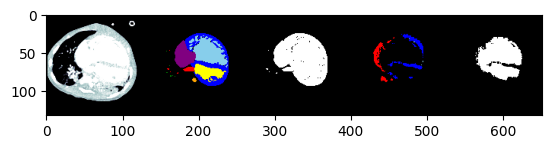

In [214]:
from heart_seg_app.utils.metrics import Metrics

def label_postprocessing(label: torch.Tensor, label_map : dict):
    label = torch.softmax(label[:8], dim=1).argmax(dim=1).squeeze(0)
    label_values = list(range(len(label_map.keys())))
    processed_label = torch.zeros(size=(len(label_values), *label.shape), dtype=torch.int32, device="cuda")
    for i, value in enumerate(label_values):
        processed_label[i] = torch.where(label == value, 1, 0)

    return processed_label

epochs = 1
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mean_dice = 0
    train_mean_dice_by_classes = torch.zeros(9, device=device)
    for batch in tqdm(val_dataloader):
        inputs, targets = batch["image"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        loss_mask = create_active_classes_mask(batch["label_map"])
        loss = loss_function(outputs, targets, mask=loss_mask)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
        outputs = label_postprocessing(outputs, batch["label_map"])
        targets = targets.int().squeeze(0)
        
        metrics = Metrics(outputs, targets)
        mean_dice = metrics.meanDice().item()
        dice_by_classes = metrics.Dice()
        train_mean_dice += mean_dice
        train_mean_dice_by_classes += dice_by_classes
        
    train_loss /= len(val_dataloader)
    train_mean_dice /= len(val_dataloader)
    train_mean_dice_by_classes /= len(val_dataloader)
    
    
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_mean_dice = 0
        val_mean_dice_by_classes = torch.zeros(9, device=device)
        for batch in tqdm(val_dataloader):
            inputs, targets = batch["image"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            loss_mask = create_active_classes_mask(batch["label_map"])
            loss = loss_function(outputs, targets, mask=loss_mask)  
            val_loss += loss.item()
            
            outputs = label_postprocessing(outputs, batch["label_map"])
            targets = targets.int().squeeze(0)
            
            metrics = Metrics(outputs, targets)
            mean_dice = metrics.meanDice().item()
            dice_by_classes = metrics.Dice()
            val_mean_dice += mean_dice
            val_mean_dice_by_classes += dice_by_classes
        val_mean_dice /= len(val_dataloader)
        val_mean_dice_by_classes /= len(val_dataloader)
        print(f"{epoch+1}/{epochs}: train_loss={train_loss:.5}, train_mean_dice={train_mean_dice:.5}",
                "by classes: ", [f"{elem:.5}" for elem in train_mean_dice_by_classes])
        print(f"{epoch+1}/{epochs}: val_loss={val_loss:.5}, val_mean_dice={val_mean_dice:.5}",
                "by classes: ", [f"{elem:.5}" for elem in val_mean_dice_by_classes])
    
        img_grid = make_grid_image("eval", inputs, targets, outputs, batch["label_map"], 50)
    plt.imshow(img_grid)